In [193]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch.utils.data import DataLoader
from torchlake.common.controller.trainer import MultiOutputClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.classification_3d.models.pointnet import PointNet, PointNetLoss
from torchlake.classification_3d.datasets.modelnet_40 import ModelNet40, MODELNET40_CLASS_NAMES, ModelNet40FromLMDB

# Setting

In [194]:
BATCH_SIZE = 64

In [195]:
artifact_path = Path("../../artifacts/pointnet")
artifact_path.mkdir(exist_ok=True)

data_path = Path("F://data/ModelNet40")

In [196]:
DEVICE = torch.device("cuda:0")

In [197]:
NUM_CLASS = len(MODELNET40_CLASS_NAMES)

# data

show mesh version for easier understanding of dataset

In [5]:
train_dataset = ModelNet40(
    data_path.as_posix(),
    mode="train",
    output_type="mesh",
    download=False,
    backend="trimesh",
)

# trimesh
train_dataset[4000][0].show() 

# open3d
# from torchlake.classification_3d.utils.plot import plot_mesh
# plot_mesh(train_dataset[4000][0])

d:\research\pytorch-implementations\.venv\Lib\site-packages\pyglet\libs\win32\__init__.py:318: UserWarning: Could not set COM MTA mode. Unexpected behavior may occur.
  warnings.warn("Could not set COM MTA mode. Unexpected behavior may occur.")


In [198]:
from scipy.spatial.transform import Rotation
import numpy as np

def sphere_normalization(data:np.ndarray) -> np.ndarray:
    # https://github.com/charlesq34/pointnet/blob/2618f72bc1a0fd21b074096e748016960d44ef55/utils/pc_util.py#L116C1-L119C36
    centroid = np.mean(data, axis=0)
    data -= centroid
    furthest_distance = np.max(np.linalg.norm(data, ord=2, axis=-1))
    data /= furthest_distance
    
    return data

def gaussian_jitter(data:np.ndarray, sigma:float=0.01, clip:float=0.05) -> np.ndarray:
    # https://github.com/charlesq34/pointnet/blob/2618f72bc1a0fd21b074096e748016960d44ef55/provider.py#L74
    noise = np.random.Generator.normal(0, sigma, data.shape)
    noise = noise.clip(-clip, clip)
    
    return data + noise

def rotate_point_cloud(data:np.ndarray) -> np.ndarray:
    angles = np.random.uniform(0, 2 * np.pi)
    rot = Rotation.from_euler('z', angles)
    
    return rot.apply(data)

def preprocess(data:np.ndarray, aug: bool = False) -> np.ndarray: 
    data = sphere_normalization(data)
    
    if aug:
        data = rotate_point_cloud(data)
        data = gaussian_jitter(data)
        
    # it is double for trimesh and scipy
    data = data.astype(np.float32)

    return data

use normalized and dense sampled point clouds for LMDB cache

In [8]:
# import lmdb

# train_dataset = ModelNet40(
#     data_path.as_posix(),
#     mode="train",
#     output_type="pointcloud",
#     transform=preprocess,
#     num_points=1<<14,
#     download=False,
#     backend="trimesh",
# )

# env = lmdb.Environment(
#     data_path.joinpath("lmdb").as_posix(),
#     map_size=1<<31,
# )
# train_dataset.to_lmdb(env)

100%|██████████| 9843/9843 [23:17<00:00,  7.05it/s]  


In [ ]:
# env.close()

In [199]:
train_dataset = ModelNet40FromLMDB(
    data_path.joinpath("lmdb").as_posix(),
    # transform=lambda x: preprocess(x, aug=True),
    transform=preprocess, # aug not helpful
    num_points=1<<10,
)

In [200]:
len(train_dataset)

9843

Text(0.5, 0.92, 'airplane')

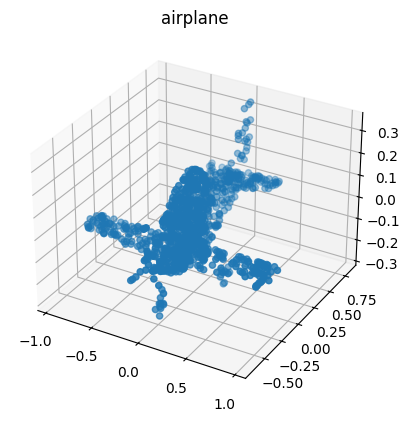

In [167]:
x, y= train_dataset[4000]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*x.T)

plt.title(MODELNET40_CLASS_NAMES[y])

In [201]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [202]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([64, 1024, 3]) torch.Size([64])


# model

In [203]:
model = PointNet(output_size=NUM_CLASS).to(DEVICE)

In [172]:
torchinfo.summary(model)

Layer (type:depth-idx)                                            Param #
PointNet                                                          --
├─ModuleDict: 1-1                                                 --
│    └─TransformModule: 2-1                                       --
│    │    └─TNet: 3-1                                             800,329
│    └─Sequential: 2-2                                            --
│    │    └─ConvBnRelu: 3-2                                       320
│    │    └─ConvBnRelu: 3-3                                       4,224
├─ModuleDict: 1-2                                                 --
│    └─TransformModule: 2-3                                       --
│    │    └─TNet: 3-4                                             1,854,592
│    └─Sequential: 2-4                                            --
│    │    └─TransformModule: 3-5                                  1,854,592
│    │    └─ConvBnRelu: 3-6                                       4,224
│  

# training

In [204]:
EPOCH = 30

In [205]:
trainer = MultiOutputClassificationTrainer(EPOCH, DEVICE)
trainer.recorder.increment_data_size(len(train_dataset))

In [206]:
criterion = PointNetLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-4)

In [207]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim, T_0=10, T_mult=2)

In [208]:
scaler = torch.cuda.amp.GradScaler()

In [209]:
training_loss = trainer.run(
    train_loader,
    model,
    optim,
    criterion,
    scheduler=scheduler,
    scaler=scaler,
)

Enable AMP: True
Training...


100%|██████████| 153/153 [00:21<00:00,  7.15it/s]


------------------------------------
Epoch 1
------------------------------------
0.04568271972197387 (0%)


100%|██████████| 153/153 [00:21<00:00,  7.14it/s]


------------------------------------
Epoch 2
------------------------------------
0.030315965495797 (-34%)


100%|██████████| 153/153 [00:20<00:00,  7.44it/s]


------------------------------------
Epoch 3
------------------------------------
0.024430740125462935 (-19%)


100%|██████████| 153/153 [00:19<00:00,  7.84it/s]


------------------------------------
Epoch 4
------------------------------------
0.02092885845719734 (-14%)


100%|██████████| 153/153 [00:15<00:00,  9.76it/s]


------------------------------------
Epoch 5
------------------------------------
0.018286422156929095 (-13%)


100%|██████████| 153/153 [00:20<00:00,  7.64it/s]


------------------------------------
Epoch 6
------------------------------------
0.01603574728827693 (-12%)


100%|██████████| 153/153 [00:18<00:00,  8.13it/s]


------------------------------------
Epoch 7
------------------------------------
0.014840509401496 (-7%)


100%|██████████| 153/153 [00:18<00:00,  8.06it/s]


------------------------------------
Epoch 8
------------------------------------
0.01328571303811461 (-10%)


100%|██████████| 153/153 [00:19<00:00,  7.98it/s]


------------------------------------
Epoch 9
------------------------------------
0.012371782430313366 (-7%)


100%|██████████| 153/153 [00:19<00:00,  8.02it/s]


------------------------------------
Epoch 10
------------------------------------
0.011621888900667897 (-6%)


100%|██████████| 153/153 [00:22<00:00,  6.68it/s]


------------------------------------
Epoch 11
------------------------------------
0.010893835892319303 (-6%)


100%|██████████| 153/153 [00:18<00:00,  8.11it/s]


------------------------------------
Epoch 12
------------------------------------
0.01057192497314942 (-3%)


100%|██████████| 153/153 [00:19<00:00,  7.76it/s]


------------------------------------
Epoch 13
------------------------------------
0.009865169667814918 (-7%)


100%|██████████| 153/153 [00:19<00:00,  7.75it/s]


------------------------------------
Epoch 14
------------------------------------
0.00964023383739432 (-2%)


100%|██████████| 153/153 [00:17<00:00,  8.57it/s]


------------------------------------
Epoch 15
------------------------------------
0.009076316766860966 (-6%)


100%|██████████| 153/153 [00:12<00:00, 12.12it/s]


------------------------------------
Epoch 16
------------------------------------
0.009025129535679507 (-1%)


100%|██████████| 153/153 [00:18<00:00,  8.21it/s]


------------------------------------
Epoch 17
------------------------------------
0.008863227318714608 (-2%)


100%|██████████| 153/153 [00:21<00:00,  6.97it/s]


------------------------------------
Epoch 18
------------------------------------
0.008373007845929472 (-6%)


100%|██████████| 153/153 [00:18<00:00,  8.18it/s]


------------------------------------
Epoch 19
------------------------------------
0.00795424616725588 (-5%)


100%|██████████| 153/153 [00:15<00:00,  9.83it/s]


------------------------------------
Epoch 20
------------------------------------
0.00815512766007739 (3%)


100%|██████████| 153/153 [00:21<00:00,  7.23it/s]


------------------------------------
Epoch 21
------------------------------------
0.007690512104864276 (-6%)


100%|██████████| 153/153 [00:21<00:00,  7.12it/s]


------------------------------------
Epoch 22
------------------------------------
0.007644609258715779 (-1%)


100%|██████████| 153/153 [00:20<00:00,  7.40it/s]


------------------------------------
Epoch 23
------------------------------------
0.007533759967190557 (-1%)


100%|██████████| 153/153 [00:20<00:00,  7.32it/s]


------------------------------------
Epoch 24
------------------------------------
0.007042222196561924 (-7%)


100%|██████████| 153/153 [00:20<00:00,  7.52it/s]


------------------------------------
Epoch 25
------------------------------------
0.00692496276702336 (-2%)


100%|██████████| 153/153 [00:20<00:00,  7.45it/s]


------------------------------------
Epoch 26
------------------------------------
0.0068739332416902195 (-1%)


100%|██████████| 153/153 [00:20<00:00,  7.44it/s]


------------------------------------
Epoch 27
------------------------------------
0.006745813760187742 (-2%)


100%|██████████| 153/153 [00:20<00:00,  7.55it/s]


------------------------------------
Epoch 28
------------------------------------
0.006584403373132231 (-2%)


100%|██████████| 153/153 [00:22<00:00,  6.71it/s]


------------------------------------
Epoch 29
------------------------------------
0.006609660213850849 (0%)


100%|██████████| 153/153 [00:21<00:00,  6.99it/s]

------------------------------------
Epoch 30
------------------------------------
0.006520886051755336 (-1%)


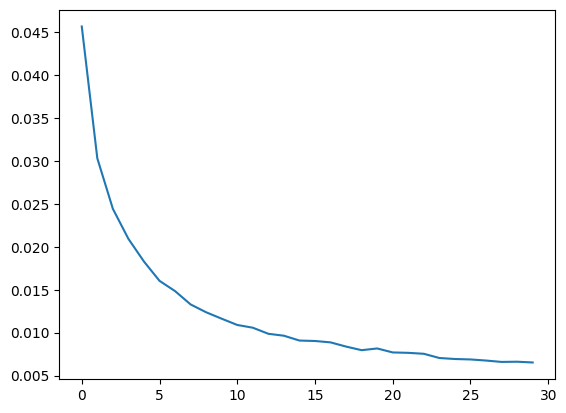

In [210]:
plt.plot(training_loss)

# inference

In [211]:
test_dataset = ModelNet40(
    data_path.as_posix(),
    mode="test",
    output_type="pointcloud",
    transform=preprocess,
    num_points=1<<10,
    download=False,
    backend="trimesh",
)

In [212]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [213]:
evaluator = ClassificationEvaluator(NUM_CLASS, DEVICE)

In [214]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 39/39 [04:34<00:00,  7.04s/it]

[[98  0  0 ...  0  0  0]
 [ 0 38  7 ...  0  0  0]
 [ 0  0 99 ...  0  0  0]
 ...
 [ 0  0  0 ... 68  0  0]
 [ 0  0  0 ...  0 10  2]
 [ 0  0  0 ...  0  1  9]]


In [216]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(range(NUM_CLASS), per_class_acc)

0         : 0.98
1         : 0.76
2         : 0.99
3         : 0.95
4         : 0.83
5         : 0.85
6         : 0.4
7         : 0.97
8         : 0.93
9         : 0.9
10        : 0.6
11        : 0.3
12        : 0.6046511627906976
13        : 0.9
14        : 0.5348837209302325
15        : 0.0
16        : 0.69
17        : 1.0
18        : 1.0
19        : 0.85
20        : 0.95
21        : 0.88
22        : 0.72
23        : 0.13953488372093023
24        : 0.85
25        : 0.6
26        : 0.81
27        : 0.6
28        : 0.92
29        : 0.75
30        : 0.81
31        : 0.7
32        : 0.6
33        : 0.92
34        : 0.8
35        : 0.86
36        : 0.73
37        : 0.68
38        : 0.5
39        : 0.45


In [217]:
per_class_acc.mean()

0.7327267441860466

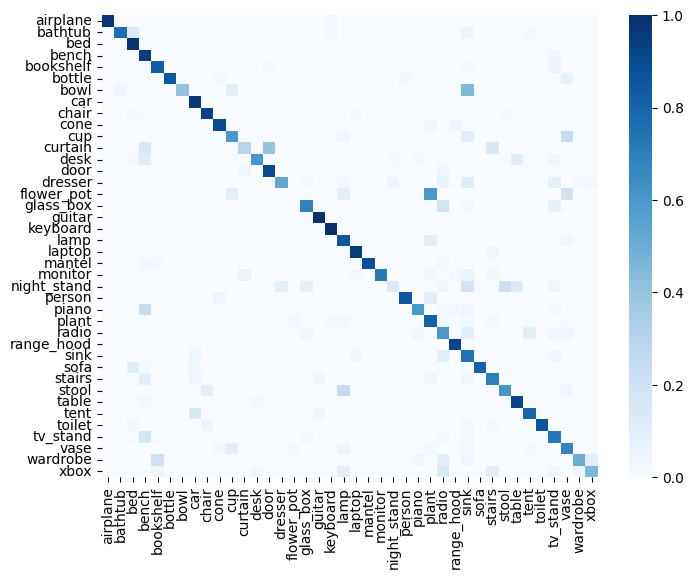

In [218]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    MODELNET40_CLASS_NAMES,
    "Blues",
    annot=False,
    figsize=(8, 6),
)

In [219]:
model_path = artifact_path / f'pointnet.pth'

In [220]:
torch.save(model.state_dict(), model_path)

In [221]:
get_file_size(model_path)

'20.39MiB'

In [222]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>